In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

<Axes: xlabel='Date'>

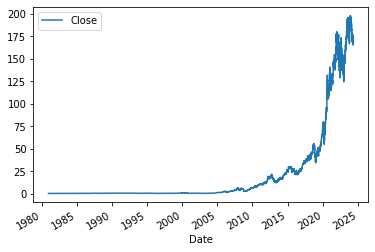

In [50]:
company = "AAPL"
stock = yf.Ticker(company)
stock = stock.history(period="max")
del stock["Dividends"]
del stock["Stock Splits"]

stock.plot.line(y="Close", use_index=True)

In [37]:
data = stock.loc["2012-01-01":"2020-12-31"].copy()
data

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03 00:00:00-05:00,12.378493,12.472223,12.366398,12.433824,302220800
2012-01-04 00:00:00-05:00,12.396634,12.538138,12.374865,12.500645,260022000
2012-01-05 00:00:00-05:00,12.546305,12.655153,12.477367,12.639431,271269600
2012-01-06 00:00:00-05:00,12.692039,12.782141,12.675409,12.771559,318292800
2012-01-09 00:00:00-05:00,12.865291,12.933321,12.739812,12.751302,394024400
...,...,...,...,...,...
2020-12-24 00:00:00-05:00,128.876596,130.976777,128.660688,129.514496,54930100
2020-12-28 00:00:00-05:00,131.496878,134.784537,131.025799,134.146637,124486200
2020-12-29 00:00:00-05:00,135.481327,136.207548,131.840352,132.360489,121047300


In [38]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [39]:
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])


In [40]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [41]:
model = Sequential()

model.add(LSTM(units=20, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=30)

Epoch 1/25
75/75 [==============================] - 5s 13ms/step - loss: 0.0084
Epoch 2/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 3/25
75/75 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 4/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0022
Epoch 5/25
75/75 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 6/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 7/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 8/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 9/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 10/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 11/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 12/25
75/75 [==============================] - 1s 13ms/step - loss: 0.0014
Epoch 13/25
75/75 [==================

In [45]:
test = stock.loc["2021-1-1":].copy()
actual_prices = test['Close'].values
total_dataset = pd.concat((data['Close'], test['Close']), axis=0)

In [46]:
model_inputs = total_dataset[len(total_dataset) - len(test) - prediction_days:]
scaled_inputs = scaler.fit_transform(model_inputs.values.reshape(-1,1))

In [47]:
x_test = []

for x in range(prediction_days, len(scaled_inputs)):
    x_test.append(scaled_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

26/26 [==============================] - 0s 5ms/step


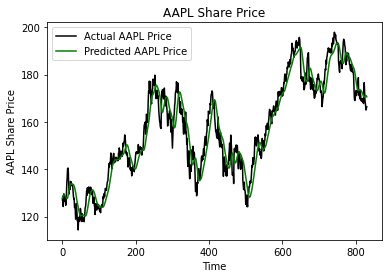

In [51]:
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [52]:
# Predict next day share price

real_data = [scaled_inputs[len(scaled_inputs) + 1 - prediction_days:len(scaled_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 24ms/step
Prediction: [[170.13011]]
